## Importing Modules


In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

## Load the Dataset

In [3]:
BASE_DIR = '/kaggle/input/utkface-new/UTKFace/'

In [4]:
# labels--> age,gender,ethinicity
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    # features are seperated witj '_'
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [5]:
# conerting to dataframe

df = pd.DataFrame()
df['image'] = image_paths
df['age'] = age_labels
df['gender'] = gender_labels

In [6]:
df.head()

,image,age,gender
0,/kaggle/input/utkface-new/UTKFace/26_0_2_20170...,26,0
1,/kaggle/input/utkface-new/UTKFace/22_1_1_20170...,22,1
2,/kaggle/input/utkface-new/UTKFace/21_1_3_20170...,21,1
3,/kaggle/input/utkface-new/UTKFace/28_0_0_20170...,28,0
4,/kaggle/input/utkface-new/UTKFace/17_1_4_20170...,17,1


In [7]:
# mapping labels for gender
gender_dict = {0:'Male',1:'Female'}

## Exploratory Data Analysis

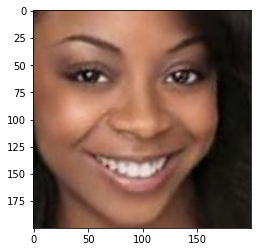

In [8]:
from PIL import Image
img = Image.open(df['image'][250])
plt.axis('on')
plt.imshow(img)

<AxesSubplot:xlabel='age', ylabel='Density'>

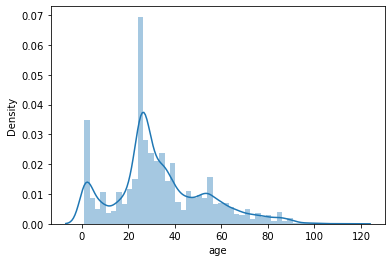

In [9]:
sns.distplot(df['age'])

<AxesSubplot:xlabel='gender', ylabel='count'>

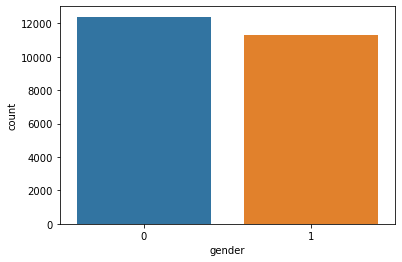

In [10]:
sns.countplot(df['gender'])

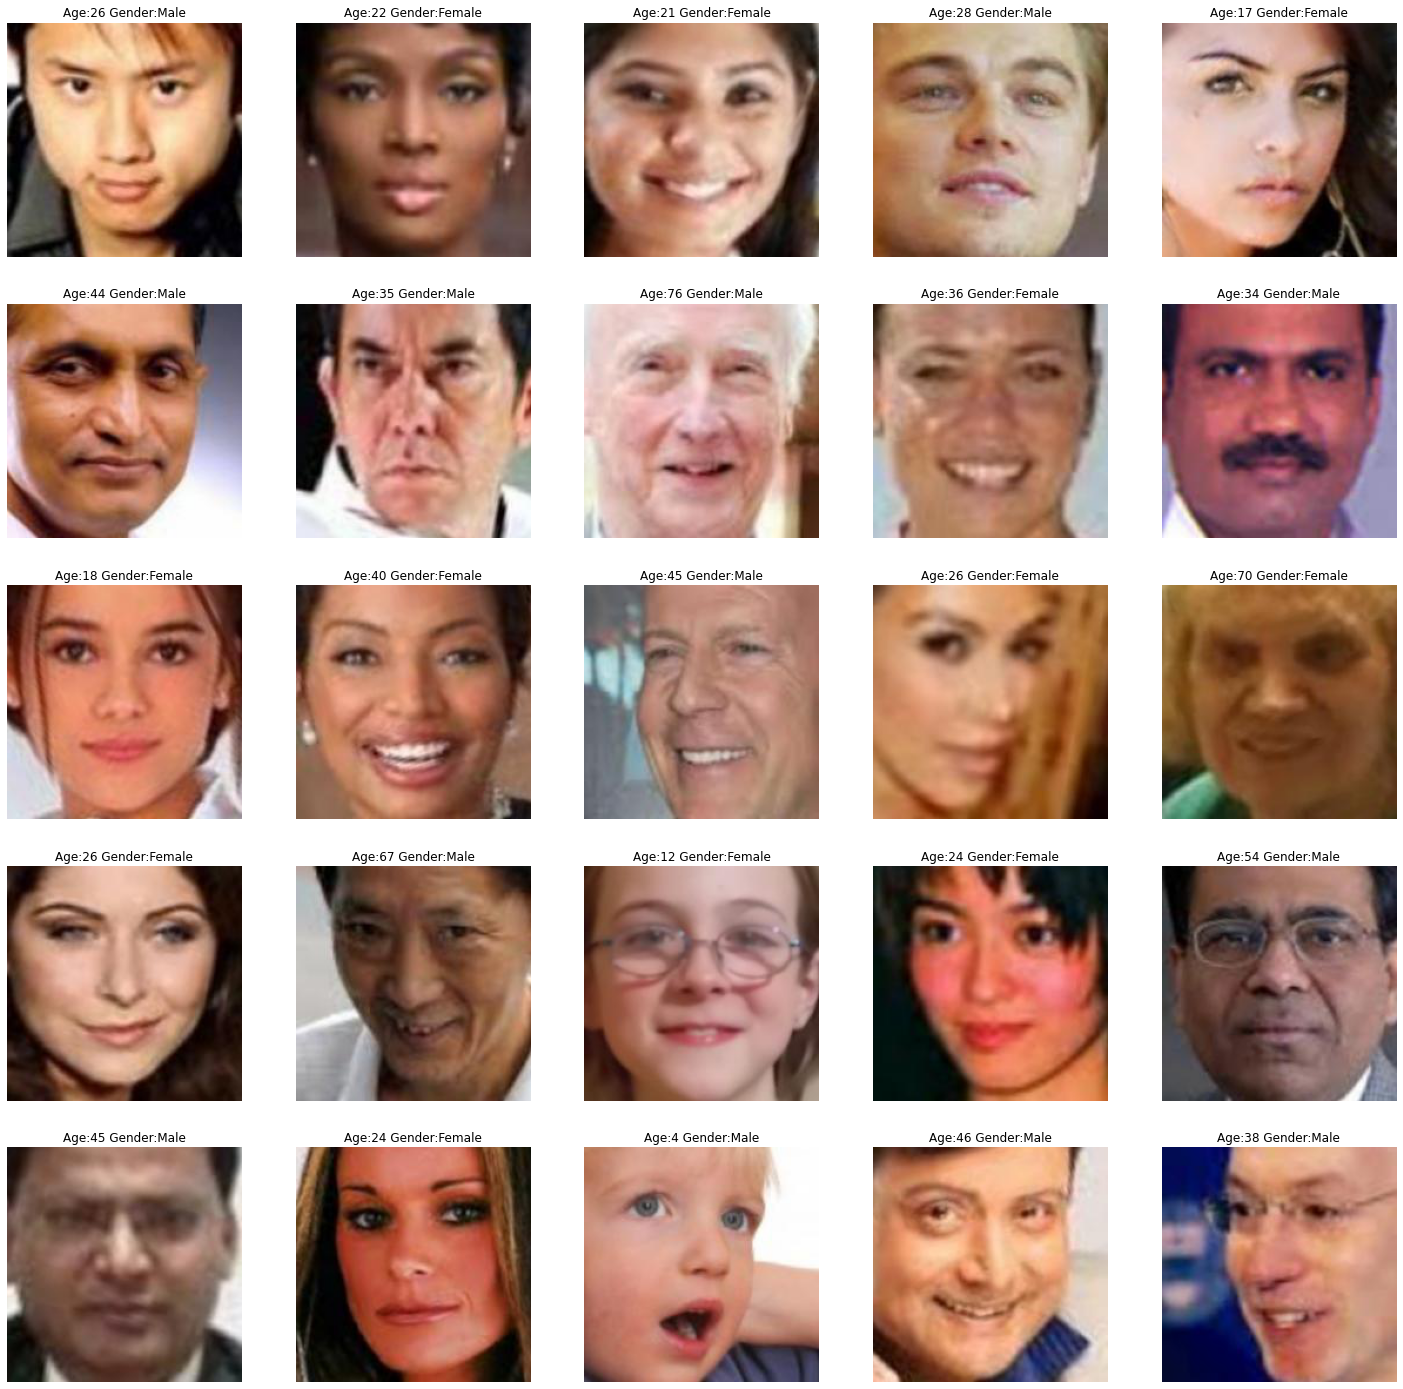

In [11]:
# To display grid of images

plt.figure(figsize=(25,25))
files = df.iloc[0:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5,5,index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age:{age} Gender:{gender_dict[gender]}")
    plt.axis('off')

## Feature Extraction

In [12]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        # to save memory we are converting it to grayscale
        img = load_img(image, grayscale=True)
        # using ANTIALIAS to remove distortion on rescaling
        img = img.resize((128,128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    # ignore this step if using RGB
    features = features.reshape(len(features),128,128,1)
    return features

In [13]:
X = extract_features(df['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [14]:
import pickle
WORKING_DIR = '/kaggle/working'

In [15]:
# storing features in pickle
pickle.dump(X, open(os.path.join(WORKING_DIR, 'X'), 'wb'))

In [16]:
# loading features from pickle
with open(os.path.join(WORKING_DIR, 'X'), 'rb') as f:
    X = pickle.load(f)

In [17]:
X.shape

(23708, 128, 128, 1)

In [18]:
# normalize the images
X = X/255.0

In [19]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [20]:
input_shape=(128,128,1)

## Model Creation

In [21]:
inputs = Input((input_shape))

# CONVOLUTIONAL LAYERS
conv_1 = Conv2D(32,kernel_size=(3,3),activation='relu')(inputs)
maxp_1 = MaxPooling2D((2,2))(conv_1)
conv_2 = Conv2D(64,kernel_size=(3,3),activation='relu')(maxp_1)
maxp_2 = MaxPooling2D((2,2))(conv_2)
conv_3 = Conv2D(128,kernel_size=(3,3),activation='relu')(maxp_2)
maxp_3 = MaxPooling2D((2,2))(conv_3)
conv_4 = Conv2D(256,kernel_size=(3,3),activation='relu')(maxp_3)
maxp_4 = MaxPooling2D((2,2))(conv_4)

flatten = Flatten()(maxp_4)

#FULLY CONNECTED LAYERS
dense_1 = Dense(256,activation='relu')(flatten)
dense_2 = Dense(256,activation='relu')(flatten)
dropout_1 = Dropout(0.3)(dense_1)
dropout_2 = Dropout(0.3)(dense_2)

output_1 = Dense(1,activation='sigmoid',name='gender_out')(dropout_1)
output_2 = Dense(1,activation='relu',name='age_out')(dropout_2)


model = Model(inputs=[inputs],outputs=[output_1,output_2])
model.compile(loss=['binary_crossentropy','mae'])

2023-01-29 19:11:05.615996: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-29 19:11:05.728127: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-29 19:11:05.729009: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-29 19:11:05.730811: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 126, 126, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 63, 63, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 61, 61, 64)   18496       max_pooling2d[0][0]              
______________________________________________________________________________________________

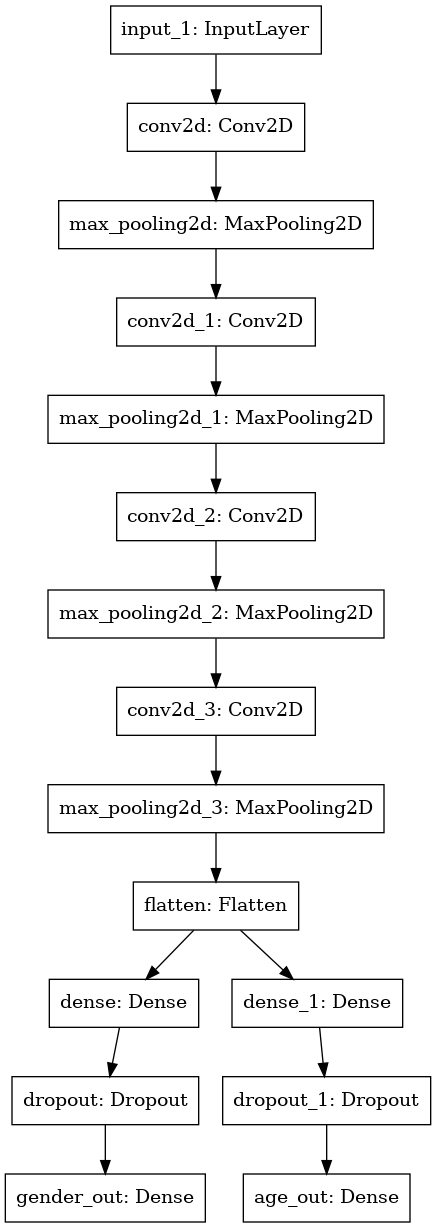

In [23]:
# Plotting the model

from tensorflow.keras.utils import plot_model
plot_model(model)

In [24]:
# TRAINING THE MODEL

history = model.fit(x=X,y=[y_gender,y_age],batch_size=32,epochs=15,validation_split=0.2)

2023-01-29 19:11:10.574863: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1242955776 exceeds 10% of free system memory.
2023-01-29 19:11:11.980501: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1242955776 exceeds 10% of free system memory.
2023-01-29 19:11:13.032823: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15


2023-01-29 19:11:15.506191: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


593/593 [==============================] - 19s 17ms/step - loss: 16.9564 - gender_out_loss: 0.7490 - age_out_loss: 16.2074 - val_loss: 13.3861 - val_gender_out_loss: 0.5446 - val_age_out_loss: 12.8416
Epoch 2/15
593/593 [==============================] - 9s 14ms/step - loss: 12.0230 - gender_out_loss: 0.4708 - age_out_loss: 11.5521 - val_loss: 10.8299 - val_gender_out_loss: 0.3891 - val_age_out_loss: 10.4409
Epoch 3/15
593/593 [==============================] - 8s 14ms/step - loss: 9.8306 - gender_out_loss: 0.3715 - age_out_loss: 9.4591 - val_loss: 8.3113 - val_gender_out_loss: 0.3284 - val_age_out_loss: 7.9829
Epoch 4/15
593/593 [==============================] - 9s 15ms/step - loss: 8.8289 - gender_out_loss: 0.3269 - age_out_loss: 8.5019 - val_loss: 8.5442 - val_gender_out_loss: 0.3196 - val_age_out_loss: 8.2245
Epoch 5/15
593/593 [==============================] - 8s 14ms/step - loss: 8.2264 - gender_out_loss: 0.2982 - age_out_loss: 7.9282 - val_loss: 7.5730 - val_gender_out_loss: 0

## Prediction

Original Gender: Female Original Age: 18
Predicted Gender: Female Predicted Age: 17


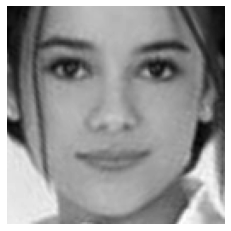

In [25]:
image_index = 10
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predicting from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Female Original Age: 24
Predicted Gender: Female Predicted Age: 22


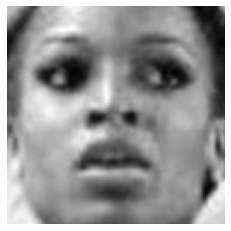

In [26]:
image_index = 1234
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predicting from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Female Original Age: 26
Predicted Gender: Female Predicted Age: 23


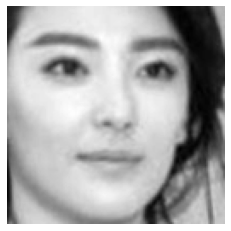

In [27]:
image_index = 1111
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predicting from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');